# Get config for spherix

This notebook will allow visualization of the dataset and generate the config txt file to use with the spherix library.

HOW TO RUN:

1) Run the generate_dset.py script. Check the sumocfg scenario in the script to ensure the correct SUMO scenario is run. Ensure that the simulation is run long enough to collect enough number of trajectories.

2) Run the notebook trajectory_preprocessor.ipynb to extract training set. Choose the number of vehicle trajectories to extract (should be at least 200)!

3) Run this notebook. Ensure that the number of trajectories to sample (again) is reasonable (should be less than the number input in 2)).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
edge_df = pd.read_csv('edge_trajectories.csv')
# edge_df = edge_df[edge_df['time'] % 10 == 0] # to adjust the temporal resolution of the basis
edge_df.head()

,Unnamed: 0,vehicle_id,time,x,y
0,3,flow_0.1,5,5.100000,-4.8
1,5,flow_0.1,6,6.123400,-4.8
2,7,flow_0.1,7,7.161216,-4.8
3,9,flow_0.1,8,8.223547,-4.8
4,11,flow_0.1,9,9.304487,-4.8


In [3]:
all_vehicle_ids = edge_df['vehicle_id'].unique()
chosen_vehicle_ids = np.random.choice(all_vehicle_ids, 175, replace=False)
traj_lens = np.zeros((175,))

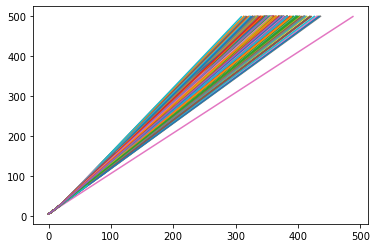

In [4]:
for i, id in enumerate(chosen_vehicle_ids):
    x_traj = edge_df[edge_df['vehicle_id'] == id]['x'].values
    y_traj = edge_df[edge_df['vehicle_id'] == id]['y'].values
    traj_lens[i] = len(edge_df[edge_df['vehicle_id'] == id].index)
    plt.plot(x_traj)

In [7]:
opt_traj_len = 320
dfx = np.zeros((100, opt_traj_len))
dfy = np.zeros((100, opt_traj_len))
dfx = dfx - np.tile(dfx[:,0], (opt_traj_len,1)).T
dfy = dfy - np.tile(dfy[:,0], (opt_traj_len,1)).T
j = 0
for i, id in enumerate(chosen_vehicle_ids):
    if j == 100:
        break
    if traj_lens[i] < opt_traj_len:
        print('Skip trajectory {:d}'.format(i))
        continue
    else:
        x_traj = edge_df[edge_df['vehicle_id'] == id]['x'].values
        y_traj = edge_df[edge_df['vehicle_id'] == id]['y'].values
        dfx[j, :opt_traj_len] = x_traj[:opt_traj_len]
        dfy[j, :opt_traj_len] = y_traj[:opt_traj_len]
        j += 1
print('Valid trajectories: {:d}'.format(j))

Skip trajectory 34
Skip trajectory 35
Skip trajectory 37
Skip trajectory 39
Skip trajectory 65
Skip trajectory 71
Skip trajectory 99
Skip trajectory 105
Valid trajectories: 100


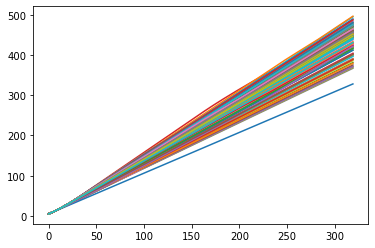

In [8]:
for i in range(100):
    plt.plot(dfx[i,:])

In [9]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
fdx = skfda.FDataGrid(dfx, np.arange(dfx.shape[1]))
fpcax = FPCA(n_components=5)
fpcax.fit(fdx)

 c:\Users\nxf67027\Anaconda3\envs\liberty\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning:The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.


FPCA(n_components=5,
     weights=array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1....
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 

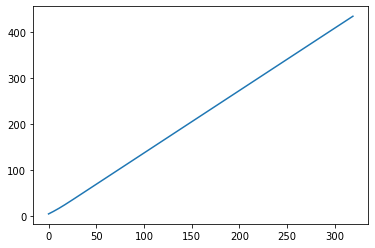

In [10]:
mean_x = fpcax.mean_.data_matrix.ravel()
plt.plot(mean_x)

In [11]:
basis_x = fpcax.components_.data_matrix.reshape(fpcax.components_.data_matrix.shape[:2])

In [12]:
scores_x = fpcax.transform(fdx)

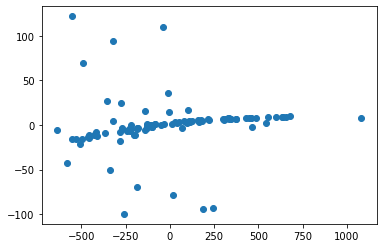

In [13]:
plt.scatter(scores_x[:,0], scores_x[:,1])

In [14]:
scores_x_var = np.var(scores_x, axis = 0)
scores_x_var

array([1.17929254e+05, 9.15527970e+02, 1.06427931e+02, 2.21335375e+01,
       8.95112424e+00])

Start writing to the config file

In [15]:
def vector_to_text(v):
    line_to_write = ''
    for m in v:
        line_to_write += (str(m) + ',')
    line_to_write = line_to_write[:len(line_to_write)-1]
    return line_to_write

In [16]:
file1 = open("spherixcfg.txt", "w") 
# first, write the mean_x
file1.write(vector_to_text(mean_x) + '\n')
# second, write the basis_x
for i in range(basis_x.shape[0]):
    file1.write(vector_to_text(basis_x[i,:]) + '\n')
# third, write the PCA scores covariance matrix
pca_scores_cov_x = np.diag(scores_x_var)
for i in range(basis_x.shape[0]):
    file1.write(vector_to_text(pca_scores_cov_x[i,:]) + '\n')
# finally, write the measurement error
file1.write(str(0.0001))
file1.close() 

Get one trajectory

In [17]:
for x in dfx[69,:]:
    print(x, ', ', end="")

5.1 , 6.125935375454603 , 7.171957014224259 , 8.239841955759795 , 9.329908634244232 , 10.438055605721429 , 11.571172797845213 , 12.724150865546427 , 13.8989430807475 , 15.094455768193818 , 16.314562497613256 , 17.556346411994195 , 18.80672174016249 , 20.053542348438 , 21.304219506233547 , 22.5465587511562 , 23.795542501298847 , 25.042587785191067 , 26.28138548695176 , 27.523744469944376 , 28.76677408139479 , 30.00715874973596 , 31.254592534176847 , 32.503396054261465 , 33.749110510120296 , 34.98843599786322 , 36.2291323899391 , 37.47383644956184 , 38.71850649990863 , 39.96011037120412 , 41.20203148032241 , 42.448971448227375 , 43.695677857041 , 44.93744212235011 , 46.1795695675655 , 47.42211614255556 , 48.66256597584065 , 49.90838005408529 , 51.152700161956055 , 52.3970518323207 , 53.63672924916362 , 54.880064665759335 , 56.124029163813134 , 57.36296743364347 , 58.6077889688166 , 59.84687505407049 , 61.0958564239843 , 62.3378911661597 , 63.587728247370414 , 64.82645718605337 , 66.07536

In [18]:
scores_x[69,:]

array([331.92902863,   7.88604993,   1.69205272,   2.3331581 ,
         1.70704941])

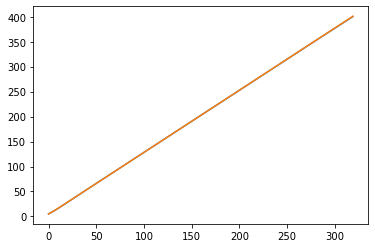

In [22]:
# trj_apprx = basis_x.T @ scores_x[69,:].reshape((5,1)) + mean_x.reshape((60,1)) 
trj_apprx = basis_x.T @ np.array([[331.92902863,   7.88604993,   1.69205272,   2.3331581 ,
         1.70704941]]).T + mean_x.reshape((320,1)) 
trj_true = dfx[69,:].reshape((320,1))

plt.plot(trj_apprx)
plt.plot(trj_true)

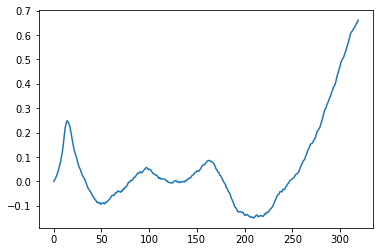

In [23]:
plt.plot(trj_true - trj_apprx)